# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
import xrft
from cdo import Cdo
# cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to clean up the temporary directory
# cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import regionmask
import xskillscore as xs
import pandas as pd
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import shutil
import gzip
import warnings

sys.path.append('/home/l/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# Description
This notebook starts to look into some track / Lagrangian frame analysis of storm Eunice in ERA5 + the forecast experiments.

# General functions
A few preprocessing functions that are used more broadly.

In [2]:
# functions to convert accumulated variables to conventional ones

## accumulated variables & scaling factors
accumulated_vars = {'tp':60 * 60 * 24 * 1e3,'ttr':1,'tsr':1,'str':1,'ssr':1,'e':1}
accumulated_var_newunits = {'tp':'mm day$^{-1}$','ttr':'W m$^{-2}$','tsr':'W m$^{-2}$','str':'W m$^{-2}$','ssr':'W m$^{-2}$','e':'m s$^{-1}$'}

## definition to convert accumulated variables to instantaneous:
def accum2rate(ds):
    ds = ds.copy()
    oindex = ds.time
    inidate = pd.to_datetime(oindex[0].values)
    
    ds = ds.diff('time') / ( ds.time.diff('time').astype(float) / 1e9 )
    ds = ds.reindex(time=oindex)
    return ds[1:]

In [3]:
# main preprocessing function

def preproc_ds(ds):
    
    ds = ds.copy().squeeze()
    
    fname = ds.encoding['source'].split('/')[-1].split('.')[0]
    
    expver = fname.split('_')[0]
    ds = ds.expand_dims({'experiment':[expver]})
    
    # set up aux data
    inidate = pd.to_datetime(ds.time[0].values)
    
    # expand dimensions to include extra info
    if not 'hDate' in ds:
        ds = ds.expand_dims({'inidate':[inidate]})
        
    if not 'number' in ds:
        ds = ds.expand_dims({'number':[0]})
        
    # put time dimension at front
    ds = ds.transpose('time',...)
    
    # convert accumulated variables into instantaneous
    for var,sf in accumulated_vars.items():
        if var in ds.keys():
            ds[var][1:] = accum2rate(ds[var]) * sf
            # set first value to equal zero [since it should be zero... but isn't always]
            ds[var][0] = 0
            ds[var].attrs['units'] = accumulated_var_newunits[var]
            
    return ds

In [4]:
# need a couple more steps for preprocessing the m-climate

def preproc_mclim(ds):
    
    ds = ds.copy().squeeze()
    
    ds = preproc_ds(ds)
    
    # create index of hours from initialisation
    ds_hours = ((ds.time-ds.time.isel(time=0))/1e9/3600).astype(int)
    # change time coord to hours coord + rename
    ds = ds.assign_coords(time=ds_hours).rename(dict(time='hour'))
    
    return ds

In [5]:
def lagrangian_frame(ds):
    ds = ds.squeeze()
    ds = ds.assign_coords(latitude=ds.latitude-ds.centroid_lat,longitude=ds.longitude-ds.centroid_lon)
    ds = ds.rename(latitude='storm_lat',longitude='storm_lon')
    ds = ds.sel(storm_lon=slice(-10,10),storm_lat=slice(10,-10))
    return ds

# Import data

In [53]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

(45.0, 65.0)

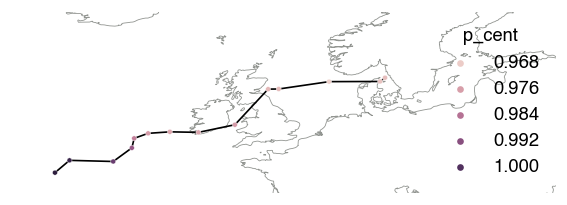

In [54]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()))
sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',color='k')
sn.scatterplot(data=ERA5_eunice_track,x='long',y='lat',hue='p_cent',zorder=10)
ax.coastlines(color='xkcd:grey',lw=0.5)
ax.axis('off')
ax.set_xlim(-30,30)
ax.set_ylim(45,65)

In [55]:
ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

In [56]:
ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(lagrangian_frame)

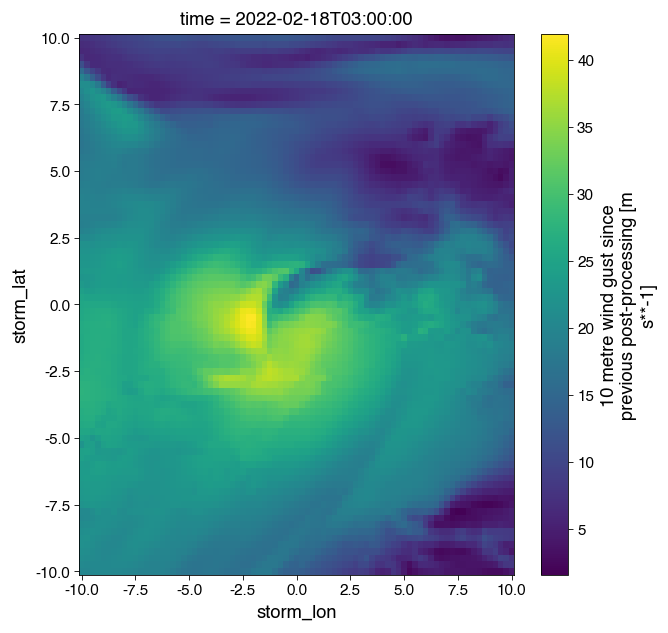

In [57]:
ERA5_eunice_stormframe.isel(time=6).fg10.plot()

## Get experimental data too

In [61]:
def import_medr_tracks(fpath):
    
    df = pd.read_hdf(fpath)
    
    fpath_split = fpath.split('/')
    exp = fpath_split[-5]
    ftype = fpath_split[-2]
    fname = fpath_split[-1]
    
    
    if ftype == 'pf':
        expid,inidate,mem = fname.split('_')
        mem = int(mem.split('m')[-1].split('.')[0])
    elif ftype == 'cf':
        expid,inidate = fname.split('_')
        inidate = inidate.split('.')[0]
        mem = 0
    
    df['expid'] = expid
    df['experiment'] = exp
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = mem
    
    return df

In [62]:
ens_fpaths = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/*/*.h5')
exp_fpaths = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/EXP/*/EU025/sfc/*/*.h5')

In [63]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks,[x for x in ens_fpaths+exp_fpaths if x.split('.')[0][-2:]!='ct'])

P1.close()

ifs_tracks = pd.concat(ifs_tracks)

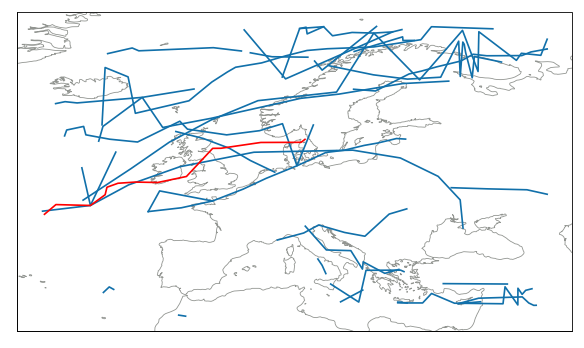

In [65]:
g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==10'),x='long',y='lat',size='uid',sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)

In [66]:
ifs_tracks_filter = ifs_tracks.groupby(['uid','inidate','experiment','number']).agg(dict(date = min, time = np.ptp, dDist = sum, long = min, lat = min, p_cent = min))
ifs_tracks_filter -= ERA5_eunice_track.groupby('uid').agg(dict(date = min, time = np.ptp, dDist = sum, long = min, lat = min, p_cent = min)).iloc[0]

Very basic selection criteria to start off with here:

In [67]:
ifs_tracks_filtered = ifs_tracks_filter.loc[(ifs_tracks_filter.date.dt.total_seconds().abs()<(12*60*60))&(ifs_tracks_filter.time>=-0.75)&(ifs_tracks_filter.dDist>-700)&(ifs_tracks_filter.long.abs()<5)&(ifs_tracks_filter.lat.abs()<5)&(ifs_tracks_filter.p_cent<1000)]

In [68]:
ifs_eunice_list = ifs_tracks.set_index(['uid','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

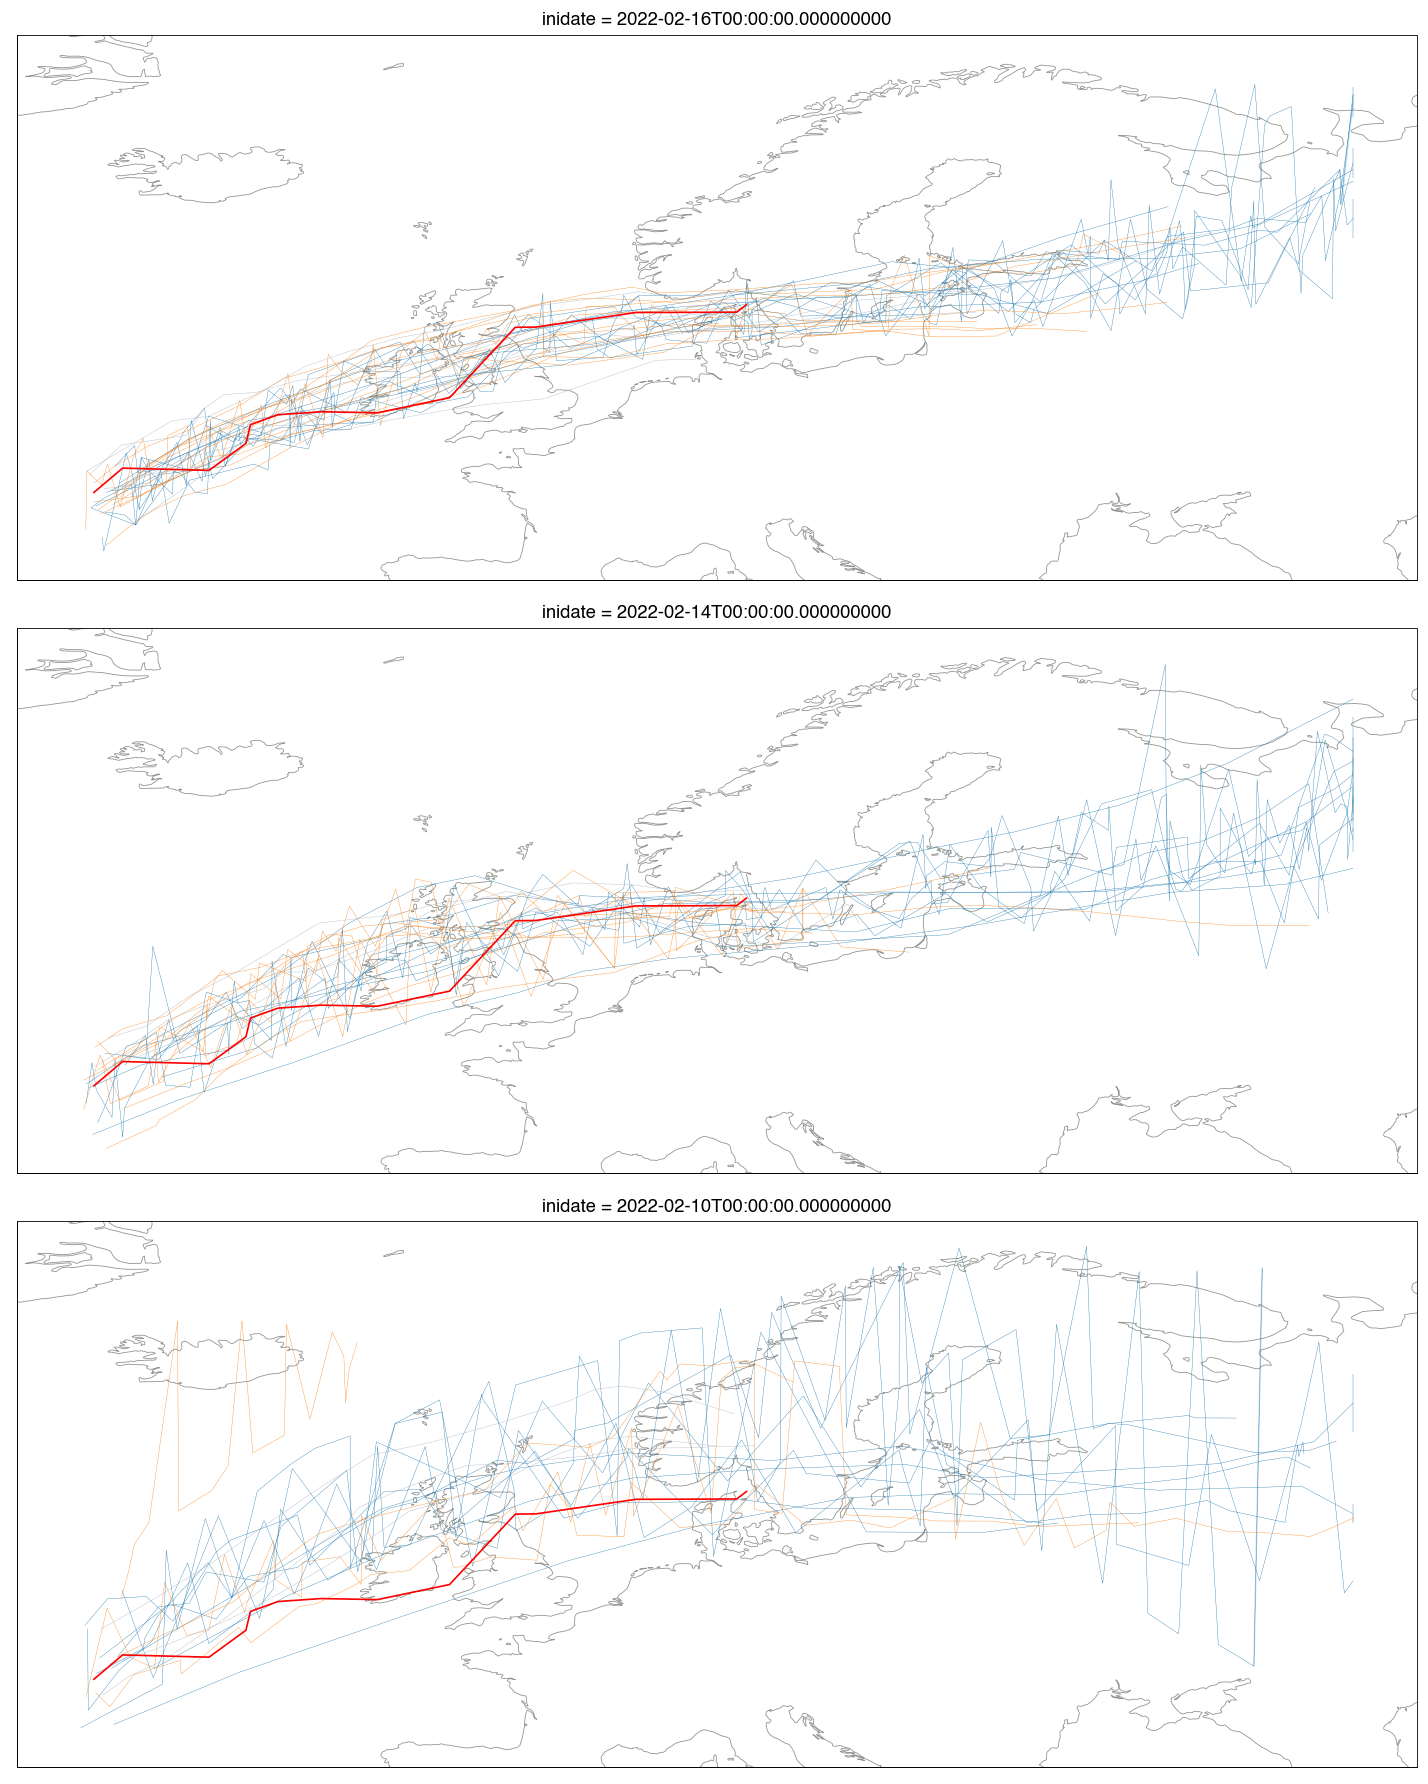

In [69]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='long',y='lat',row='inidate',hue='experiment',size='uid',sizes=(0.2,0.2),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=ERA5_eunice_track,x='long',y='lat',legend=False,color='r',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()];

In [70]:
def get_stormframe_fields(track_df):
    
    exp = track_df.experiment.unique()[0]
    number = track_df.number.unique()[0]
    inidate = pd.to_datetime(track_df.inidate.unique()[0]).strftime('%Y-%m-%d')
    
    if exp in ['incr','pi']:
        exp = 'EXP/'+exp
    if number == 0:
        ftype = 'cf'
    else:
        ftype = 'pf'
        
    ds_path = glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/{}/EU025/sfc/{}/*_{}.nc'.format(exp,ftype,inidate))[0]
    
    ds = xr.open_dataset(ds_path)
    if ftype=='pf':
        ds = ds.sel(number=number)
    time_intersection = sorted(list(set(ds.time.values).intersection(track_df.date.values)))
    ds = ds.sel(time = time_intersection)
    track_df = track_df.loc[track_df.date.isin(time_intersection)]
    ds['centroid_lon'] = ('time',(track_df.long*4).round()/4)
    ds['centroid_lat'] = ('time',(track_df.lat*4).round()/4)
    
    return ds.groupby('time').apply(lagrangian_frame)

In [71]:
testrack = get_stormframe_fields(ifs_eunice_list.query('inidate=="2022-02-14" & experiment=="incr" & number==1'))

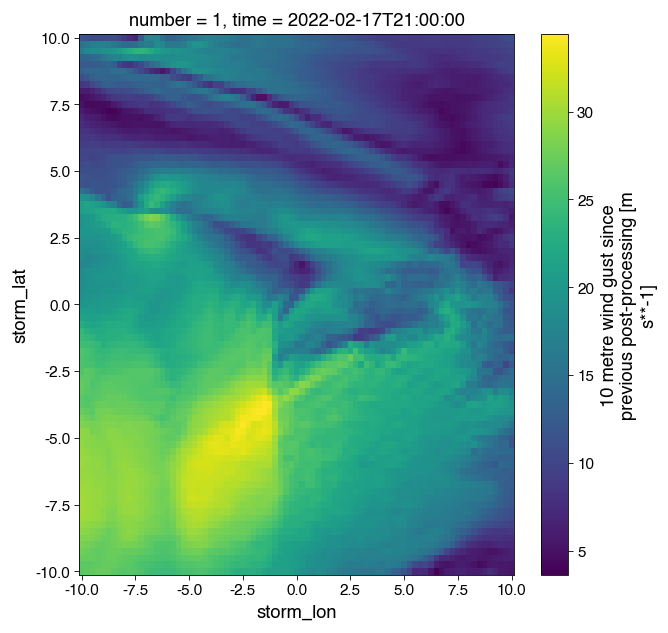

In [160]:
testrack.isel(time=5).fg10.plot()

In [73]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','uid']).agg(dict(p_cent=min,dDist=sum,date=min)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - pd.to_datetime('2022-02-18 12')).dt.total_seconds()

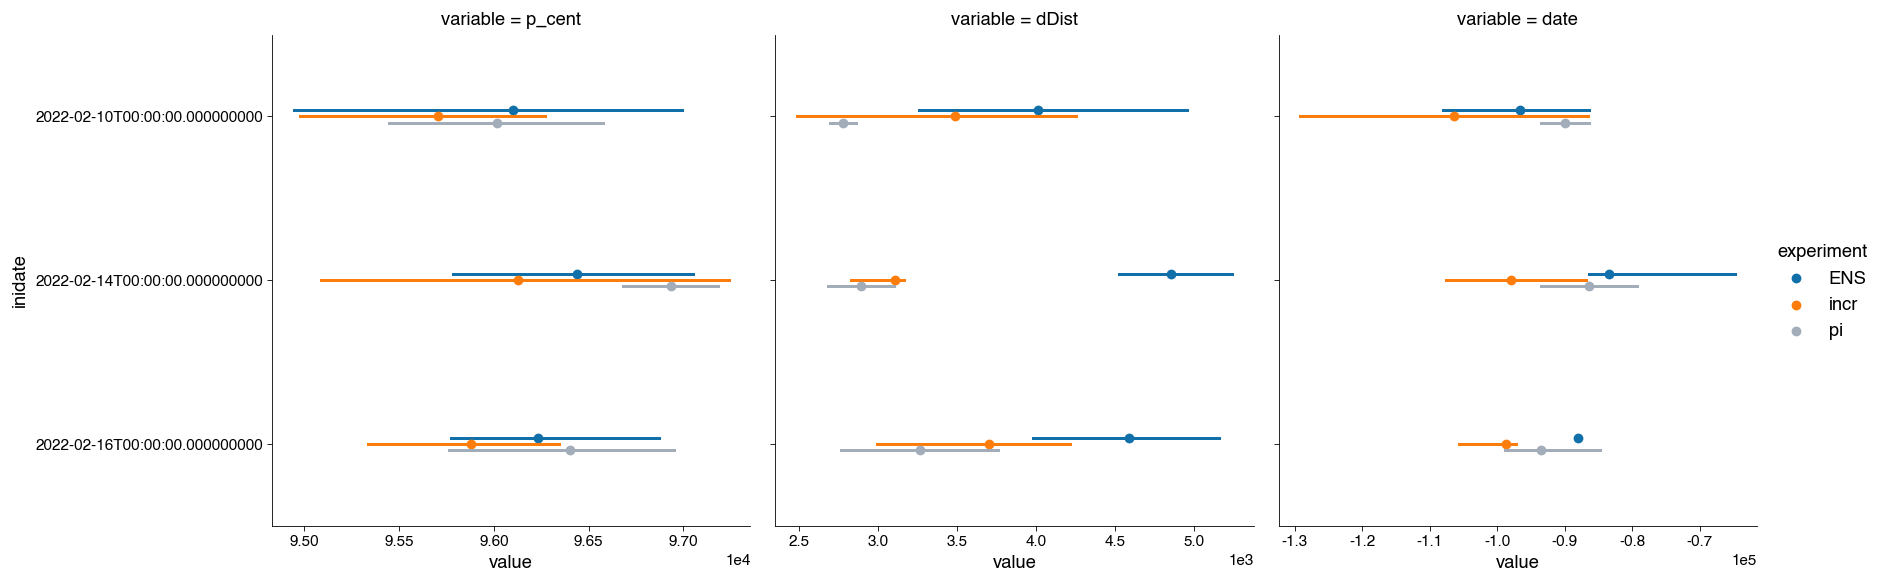

In [74]:
sn.catplot(data=ifs_eunice_list_stats.set_index(['experiment','inidate']).drop(['uid','number'],axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'},axis=1),
           x='value',col='variable',y='inidate',hue='experiment',kind='point',join=False,dodge=True,errorbar=('pi',66),n_boot=10000,sharex=False)

## Testing TempestExtremes implementation
Doesn't really seem to work as well as the Crawford cycloneTracking algorithm...